In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import scipy.stats as st
from scipy import spatial
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier
from skopt import BayesSearchCV

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.utils import resample
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, PowerTransformer, QuantileTransformer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif

In [3]:
RANDOM_STATE = 177013

### Data review

In [4]:
df = pd.read_csv('framingham_heart_disease.csv')

In [5]:
df.sample(10, random_state = RANDOM_STATE)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
3815,1,60,1.0,0,0.0,0.0,0,0,0,266.0,115.5,82.5,23.68,82.0,83.0,1
1976,1,41,1.0,1,40.0,0.0,0,0,0,224.0,126.0,79.0,22.94,53.0,68.0,0
4198,0,52,1.0,1,30.0,0.0,0,1,0,240.0,157.5,105.0,29.64,72.0,80.0,0
1231,1,42,4.0,0,0.0,0.0,0,0,0,195.0,112.0,74.5,23.37,58.0,110.0,0
3957,1,41,4.0,1,40.0,0.0,0,0,0,254.0,141.0,100.0,27.68,110.0,NaN,1
1182,1,38,2.0,1,43.0,0.0,0,1,0,170.0,130.0,94.0,23.90,110.0,75.0,0
2136,0,56,2.0,0,0.0,0.0,0,1,0,290.0,185.0,107.5,26.45,82.0,84.0,1
955,1,57,1.0,1,20.0,0.0,0,1,0,257.0,158.5,107.0,27.10,66.0,67.0,0
2374,1,45,1.0,0,0.0,0.0,0,1,0,218.0,133.0,87.0,31.90,88.0,115.0,0
1529,0,43,2.0,1,20.0,0.0,0,0,0,195.0,104.0,57.0,20.86,75.0,78.0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
male,4238.0,0.429212,0.495022,0.00,0.00,0.0,1.000,1.0
age,4238.0,49.584946,8.572160,32.00,42.00,49.0,56.000,70.0
education,4133.0,1.978950,1.019791,1.00,1.00,2.0,3.000,4.0
currentSmoker,4238.0,0.494101,0.500024,0.00,0.00,0.0,1.000,1.0
cigsPerDay,4209.0,9.003089,11.920094,0.00,0.00,0.0,20.000,70.0
BPMeds,4185.0,0.029630,0.169584,0.00,0.00,0.0,0.000,1.0
prevalentStroke,4238.0,0.005899,0.076587,0.00,0.00,0.0,0.000,1.0
prevalentHyp,4238.0,0.310524,0.462763,0.00,0.00,0.0,1.000,1.0
diabetes,4238.0,0.025720,0.158316,0.00,0.00,0.0,0.000,1.0
totChol,4188.0,236.721585,44.590334,107.00,206.00,234.0,263.000,696.0


In [8]:
df.isna().mean()

male               0.000000
age                0.000000
education          0.024776
currentSmoker      0.000000
cigsPerDay         0.006843
BPMeds             0.012506
prevalentStroke    0.000000
prevalentHyp       0.000000
diabetes           0.000000
totChol            0.011798
sysBP              0.000000
diaBP              0.000000
BMI                0.004483
heartRate          0.000236
glucose            0.091553
TenYearCHD         0.000000
dtype: float64

In [9]:
# Drop the rows with missing data, we don't want to bother yet.
df = df.dropna()

## Statistical analysis example

In [10]:
# Statistical tests with 1% alpha:
def ttest (set1, set2):
    alpha = 0.01
    result = st.ttest_ind (set1, set2, equal_var=False) 

    print ('Mean difference t-test:')
    print ('P-value:', result.pvalue)

    if (result.pvalue < alpha):
        print("Rejecting the null hypothesis: means differ significantly.")
    else:
        print("Failed to reject the null hypothesis: means do not appear to differ significantly.")

def utest (set1, set2):
    alpha = 0.01
    result = st.mannwhitneyu (set1, set2) 

    print ('Distribution u-test:')
    print ('P-value:', result.pvalue)

    if (result.pvalue < alpha):
        print("Rejecting the null hypothesis: distributions differ significantly.")
    else:
        print("Failed to reject the null hypothesis: distributions do not appear to differ significantly.")

### BMI

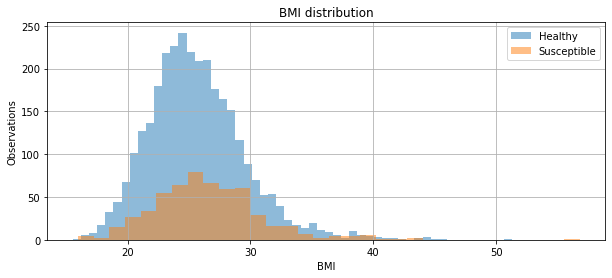

In [11]:
_, ax = df.groupby('TenYearCHD')['BMI'].hist(bins='fd', figsize=(10,4), alpha=0.5);
ax.set(xlabel='BMI', ylabel='Observations', title='BMI distribution')
ax.legend(['Healthy', 'Susceptible']);

In [12]:
df.groupby('TenYearCHD')['BMI'].agg(['mean','median'])

,mean,median
TenYearCHD,,
0,25.642975,25.23
1,26.569838,26.11


In [13]:
ttest(df.query('TenYearCHD == 1')['BMI'], df.query('TenYearCHD == 0')['BMI'])

Mean difference t-test:
P-value: 6.434436738627063e-06
Rejecting the null hypothesis: means differ significantly.


In [14]:
utest(df.query('TenYearCHD == 1')['BMI'], df.query('TenYearCHD == 0')['BMI'])

Distribution u-test:
P-value: 1.58433804359e-06
Rejecting the null hypothesis: distributions differ significantly.


### Cholesterol

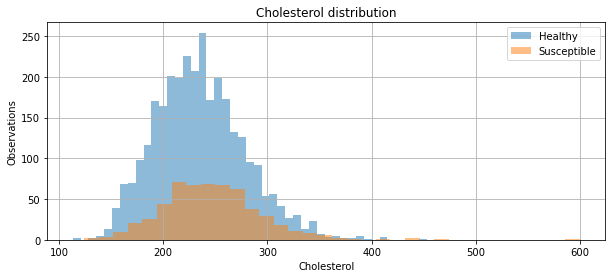

In [15]:
_, ax = df.groupby('TenYearCHD')['totChol'].hist(bins='fd', figsize=(10,4), alpha=0.5);
ax.set(xlabel='Cholesterol', ylabel='Observations', title='Cholesterol distribution')
ax.legend(['Healthy', 'Susceptible']);

In [16]:
df.groupby('TenYearCHD')['totChol'].agg(['mean','median'])

,mean,median
TenYearCHD,,
0,235.169732,232.0
1,246.350090,243.0


In [17]:
ttest(df.query('TenYearCHD == 1')['totChol'], df.query('TenYearCHD == 0')['totChol'])

Mean difference t-test:
P-value: 4.1987082826151396e-07
Rejecting the null hypothesis: means differ significantly.


In [18]:
utest(df.query('TenYearCHD == 1')['totChol'], df.query('TenYearCHD == 0')['totChol'])

Distribution u-test:
P-value: 2.0183978125359892e-07
Rejecting the null hypothesis: distributions differ significantly.


### Glucose

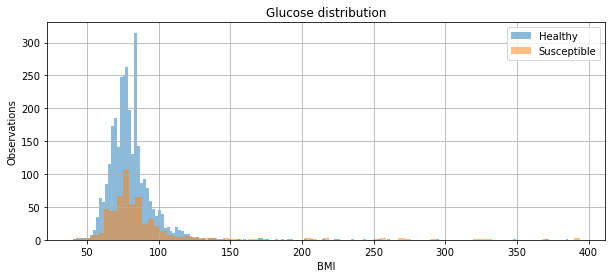

In [19]:
_, ax = df.groupby('TenYearCHD')['glucose'].hist(bins='fd', figsize=(10,4), alpha=0.5);
ax.set(xlabel='BMI', ylabel='Observations', title='Glucose distribution')
ax.legend(['Healthy', 'Susceptible']);

In [20]:
df.groupby('TenYearCHD')['glucose'].agg(['mean','median'])

,mean,median
TenYearCHD,,
0,80.620200,78.0
1,88.732496,79.0


In [21]:
ttest(df.query('TenYearCHD == 1')['glucose'], df.query('TenYearCHD == 0')['glucose'])

Mean difference t-test:
P-value: 5.0586937206941634e-06
Rejecting the null hypothesis: means differ significantly.


In [22]:
utest(df.query('TenYearCHD == 1')['glucose'], df.query('TenYearCHD == 0')['glucose'])

Distribution u-test:
P-value: 0.0009962163497917315
Rejecting the null hypothesis: distributions differ significantly.


## Multivariate outlier detection by Mahalanobis distance (2d example)

In [23]:
outlier_space = ['BMI', 'glucose']

# Covariance matrix:
covariance = np.cov(df[outlier_space], rowvar=False)
covariance_pm1 = np.linalg.matrix_power(covariance, -1)

# Distribution center:
center = np.mean(df[outlier_space], axis=0)

In [24]:
def calc_distance(row):
    return spatial.distance.mahalanobis(row, center, covariance_pm1)

In [25]:
# Distance from the mean point for every observation:
distance = df[outlier_space].apply(calc_distance, axis=1)

In [26]:
# Adjustable:
limit = distance.quantile(0.99)

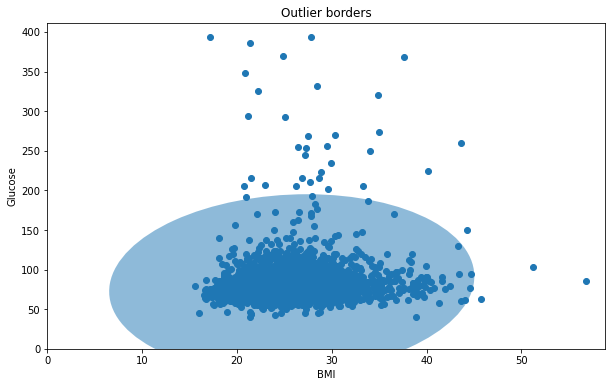

In [27]:
lambda_, v = np.linalg.eig(covariance)
lambda_ = np.sqrt(lambda_)
ellipse = patches.Ellipse(xy=(center[0], center[1]),
                  width=lambda_[0] * limit * 2, height=lambda_[1] * limit * 2,
                  angle=np.rad2deg(np.arccos(v[0, 0])))
ellipse.set_alpha(0.5)
fig = plt.figure(figsize=(10,6))
ax = plt.subplot()
plt.scatter(x=df['BMI'], y=df['glucose']);
ax.add_artist(ellipse)
ax.set(xlim=(0), ylim=(0), title='Outlier borders', xlabel='BMI', ylabel='Glucose');

Note this is a bit of cheating, since we end up dropping from the test set as well. Clamping to border values would probably still work.

In [28]:
# Comment this out to test without outlier exclusion:
df = df[distance < limit]
df[outlier_space].max()

BMI         44.71
glucose    193.00
dtype: float64

## Preparing the sets

In [29]:
df_features = df.drop(['TenYearCHD'], axis=1)
df_target = df['TenYearCHD']
features_train, features_test, target_train, target_test = train_test_split(df_features, df_target,
                                                                            test_size=0.2, random_state=RANDOM_STATE)

### (Optional) Oversampling

Does not really help much, but this is one option.

In [30]:
df_train = features_train.copy()
df_train['TenYearCHD'] = target_train
df_healthy =  df_train[df_train['TenYearCHD']==0]
df_ill = df_train[df_train['TenYearCHD']==1]

df_ill_oversampled = resample(df_ill, replace=True, n_samples=len(df_healthy), random_state=RANDOM_STATE)
df_train_oversampled = pd.concat([df_healthy, df_ill_oversampled])

df_train_oversampled['TenYearCHD'].value_counts()

0    2474
1    2474
Name: TenYearCHD, dtype: int64

In [31]:
features_train_oversampled = df_train_oversampled.drop(['TenYearCHD'], axis=1)
target_train_oversampled = df_train_oversampled['TenYearCHD']

In [32]:
# Uncomment to test without resampling.
#features_train_oversampled = features_train
#target_train_oversampled = target_train

## Additional feature selection

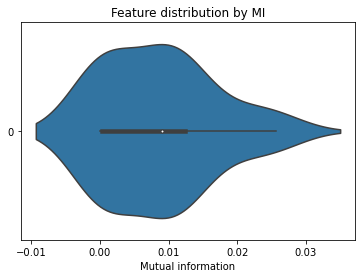

In [33]:
mi_scores = mutual_info_classif(features_train, target_train, random_state=RANDOM_STATE)
sns.violinplot(data=mi_scores, orient='h').set(title='Feature distribution by MI', xlabel='Mutual information');

In [34]:
mic_data = pd.DataFrame()
mic_data['feature'] = features_train.columns
mic_data['MIC'] = mi_scores
  
mic_data.sort_values(by='MIC', ascending=False)

,feature,MIC
1,age,0.025627
10,sysBP,0.021359
14,glucose,0.014130
7,prevalentHyp,0.012816
11,diaBP,0.011861
12,BMI,0.009830
3,currentSmoker,0.009815
8,diabetes,0.008979
2,education,0.008924
0,male,0.003192


Some features appear irrelevant to to target by this criterion. We may consider dropping those.

In [35]:
vif_data = pd.DataFrame()
vif_data['feature'] = features_train.columns
vif_data['VIF'] = [variance_inflation_factor(features_train.values, i) for i in range(len(features_train.columns))]
  
vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
11,diaBP,136.235354
10,sysBP,134.805345
12,BMI,46.319107
1,age,40.883381
13,heartRate,40.335466
14,glucose,33.506659
9,totChol,32.320394
3,currentSmoker,4.895800
2,education,4.737827
4,cigsPerDay,4.248496


Double digit and higher VIF signifies dangerous correlation between features. At least one of `diaBP` and `sysBP` need to be dealt with somehow (dropped or otherwise merged).

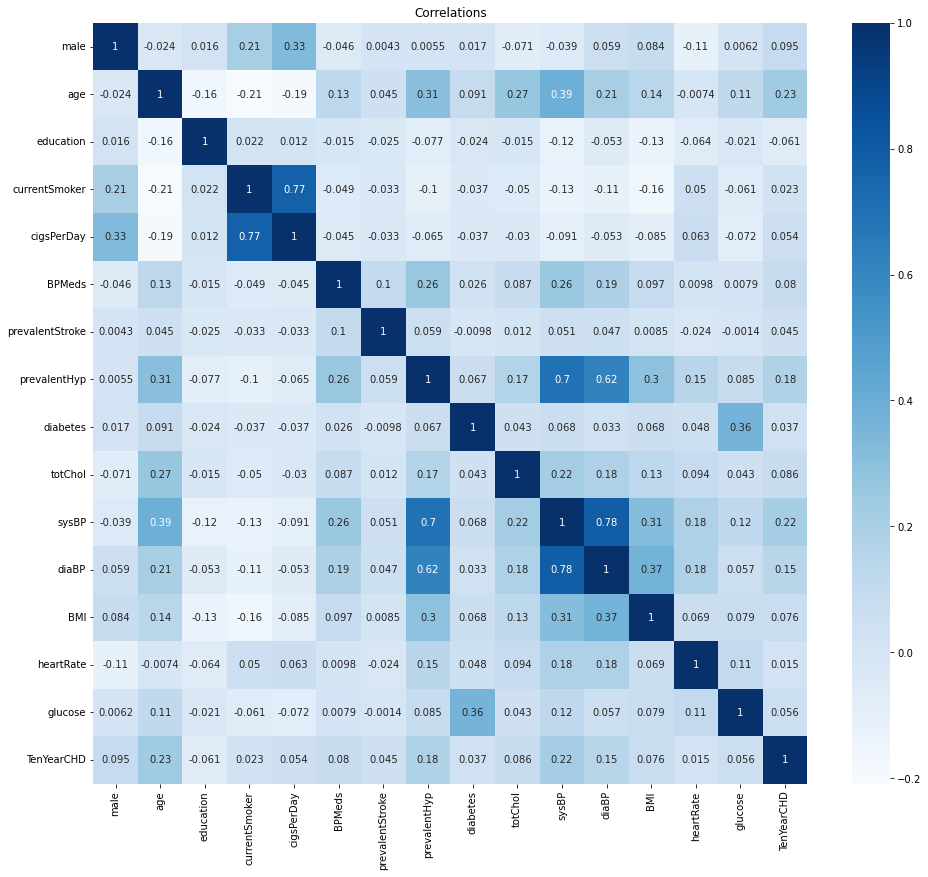

In [36]:
plt.figure(figsize=(16,14))
sns.heatmap(df.corr(), annot=True, cmap='Blues').set(title='Correlations');

Dropping some features:

In [37]:
features_train_oversampled = features_train_oversampled.drop(['diaBP', 'BPMeds', 'prevalentStroke', 'cigsPerDay'], axis=1)
features_test = features_test.drop(['diaBP', 'BPMeds', 'prevalentStroke', 'cigsPerDay'], axis=1)

## Modeling

### Baseline

In [38]:
for strategy in ['most_frequent', 'prior', 'stratified', 'uniform']:
    dummy = DummyClassifier(strategy=strategy)
    dummy.fit(features_train, target_train)
    dummy_predictions = dummy.predict(features_test)
       
    f1 = f1_score(target_test, dummy_predictions)
    acc = accuracy_score(target_test, dummy_predictions)
    roc_auc = roc_auc_score(target_test, dummy_predictions)
    
    print(f'Strategy: {strategy}, F1: {f1:.1f}, ROC_AUC: {roc_auc:.1f}, accuracy: {acc:.1f}')

Strategy: most_frequent, F1: 0.0, ROC_AUC: 0.5, accuracy: 0.8
Strategy: prior, F1: 0.0, ROC_AUC: 0.5, accuracy: 0.8
Strategy: stratified, F1: 0.1, ROC_AUC: 0.5, accuracy: 0.7
Strategy: uniform, F1: 0.2, ROC_AUC: 0.5, accuracy: 0.5


### Training some models

In [39]:
scaler_list = [MinMaxScaler(),
               StandardScaler(),
               PowerTransformer(),
               QuantileTransformer(random_state=RANDOM_STATE),
               QuantileTransformer(random_state=RANDOM_STATE, output_distribution='normal')]

In [40]:
def optimize(model, params, X, y):
    name = f'{type(model).__name__}'
    print(f'Optimizing {name}...')
    pipe = Pipeline([('scaler', StandardScaler()), ('classifier', model)]) 
    gcv = BayesSearchCV(pipe, search_spaces=params, cv=4, scoring='f1', random_state=RANDOM_STATE, n_jobs=-1)
    gcv.fit(X, y)
    print(f'Best params: {dict(gcv.best_params_)}')
    print(f'F1: {(gcv.best_score_):.2f}')
    return gcv.best_estimator_

In [41]:
%%time
linear_params = {
                    'scaler': scaler_list,
                    'classifier__fit_intercept':[True, False],
                }
best_linear = optimize(LogisticRegression(n_jobs=-1), linear_params, features_train_oversampled, target_train_oversampled)

Optimizing LogisticRegression...


Best params: {'classifier__fit_intercept': False, 'scaler': StandardScaler()}
F1: 0.35
CPU times: user 1min 14s, sys: 1min 42s, total: 2min 56s
Wall time: 30.4 s


In [42]:
%%time
forest_params = {
                    'scaler': scaler_list,
                    'classifier__max_depth' : list(range(5, 25)),
                    'classifier__n_estimators' : [100, 200, 500, 1000],
                    'classifier__max_features' : ['sqrt']
                }
best_forest = optimize(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1), forest_params, features_train_oversampled, target_train_oversampled)

Optimizing RandomForestClassifier...
Best params: {'classifier__max_depth': 15, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100, 'scaler': QuantileTransformer(output_distribution='normal', random_state=177013)}
F1: 0.09
CPU times: user 1min 29s, sys: 2min, total: 3min 29s
Wall time: 1min 1s


In [43]:
%%time
best_et = optimize(ExtraTreesClassifier(random_state=RANDOM_STATE, n_jobs=-1), forest_params, features_train_oversampled, target_train_oversampled)

Optimizing ExtraTreesClassifier...
Best params: {'classifier__max_depth': 23, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100, 'scaler': QuantileTransformer(random_state=177013)}
F1: 0.13
CPU times: user 1min 26s, sys: 1min 56s, total: 3min 22s
Wall time: 55.7 s


In [44]:
%%time
xgb_params = {
                    'scaler': scaler_list,
                    'classifier__max_depth' : list(range(1,5)),
                    'classifier__n_estimators' : [100, 200, 300, 400],
                    'classifier__min_child_weight' : list(range(1,5)),
                    #'classifier__scale_pos_weight' : list(range(1, 10))
                }
best_xgb = optimize(XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1), xgb_params, features_train_oversampled, target_train_oversampled)

Optimizing XGBClassifier...
Best params: {'classifier__max_depth': 4, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 400, 'scaler': QuantileTransformer(output_distribution='normal', random_state=177013)}
F1: 0.22
CPU times: user 1min 29s, sys: 1min 55s, total: 3min 24s
Wall time: 49.9 s


In [45]:
def calculate_metrics(probabilities, target_test):
    predictions = (probabilities > 0.5)
    f1 = f1_score(target_test, predictions)
    roc_auc = roc_auc_score(target_test, probabilities)
    acc = accuracy_score(target_test, predictions)
    ap = average_precision_score(target_test, probabilities)
    cmatrix = confusion_matrix(target_test, predictions)
    
    fpr, tpr, _ = roc_curve(target_test, probabilities)
    precision, recall, thresholds = precision_recall_curve(target_test, probabilities)
    f1_scores = 2 * recall * precision / (recall + precision)
    f1_scores = np.nan_to_num(f1_scores)
    best_f1 = np.max(f1_scores)
    best_thresh = thresholds[np.argmax(f1_scores)]

    pred_t = (probabilities > best_thresh)
    best_cmatrix = confusion_matrix(target_test, pred_t)
    
    return f1, best_f1, roc_auc, acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix

def visualize_tests(probabilities, target_test):
    cmatrices = []

    fig, axes = plt.subplots(1, 2, figsize=(15,6))
    axes[0].plot([0, 1], linestyle='--')
    axes[1].plot([0.5, 0.5], linestyle='--')

    print('Processing validation set, please wait warmly...')
    f1, best_f1, roc_auc, acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix = calculate_metrics (probabilities, target_test)
    axes[0].plot (fpr, tpr);
    axes[1].plot (recall, precision);
    print (f'F1: {f1:.2f} (max: {best_f1:.2f} at {best_thresh:.2f} threshold), ROC_AUC: {roc_auc:.3f}, accuracy: {acc:.0%}, AP (PR_AUC): {ap:.2f}')
    cmatrices.append(cmatrix)
    cmatrices.append(best_cmatrix)
    
    axes[0].set (xlabel='FPR', ylabel='TPR', title='ROC curve', xlim=(0,1), ylim=(0,1))
    axes[1].set (xlabel='Recall', ylabel='Precision', title='PR curve', xlim=(0,1), ylim=(0,1))
    
    fig, axes = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)
    for cmatrix, ax, title in zip(cmatrices, axes.flat, ['Confusion Maxtrix', 'Confusion Maxtrix (optimal F1 threshold)']):
        sns.heatmap(cmatrix, ax=ax, annot=True, cmap='Blues', fmt='d').set(title=title, xlabel='Prediction', ylabel='Reality')
    
    return best_thresh

In [46]:
probs0 = best_linear.predict_proba(features_test)[:,1]

Processing validation set, please wait warmly...
F1: 0.37 (max: 0.44 at 0.56 threshold), ROC_AUC: 0.731, accuracy: 59%, AP (PR_AUC): 0.32


0.5649232458327323

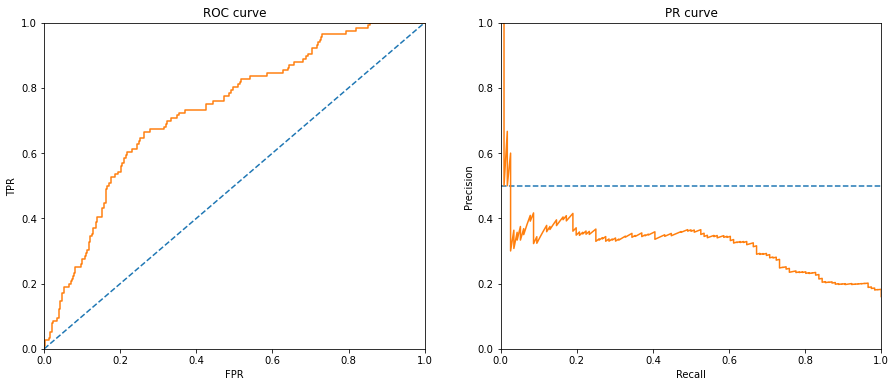

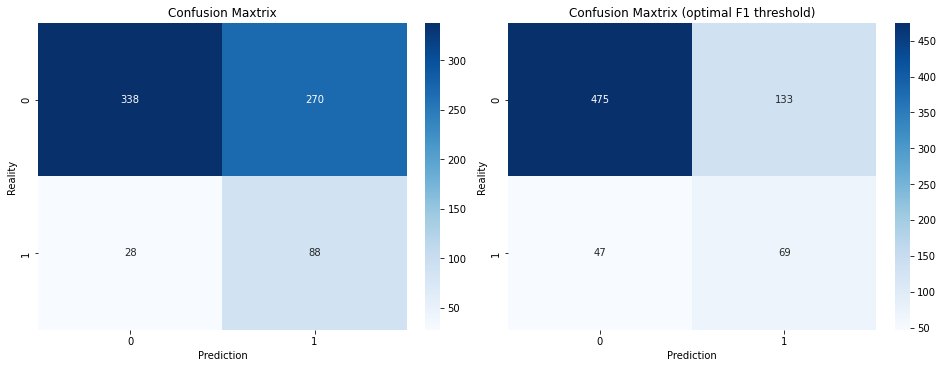

In [47]:
visualize_tests(probs0, target_test)

In [48]:
probs1 = best_forest.predict_proba(features_test)[:,1]

Processing validation set, please wait warmly...
F1: 0.10 (max: 0.47 at 0.23 threshold), ROC_AUC: 0.724, accuracy: 83%, AP (PR_AUC): 0.34


0.23376928338736366

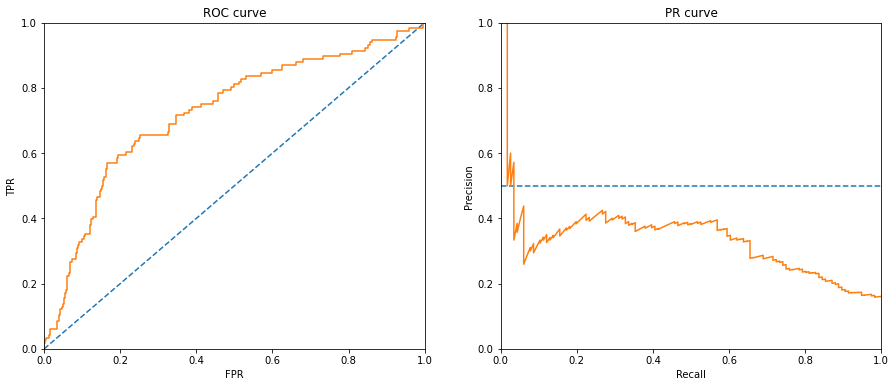

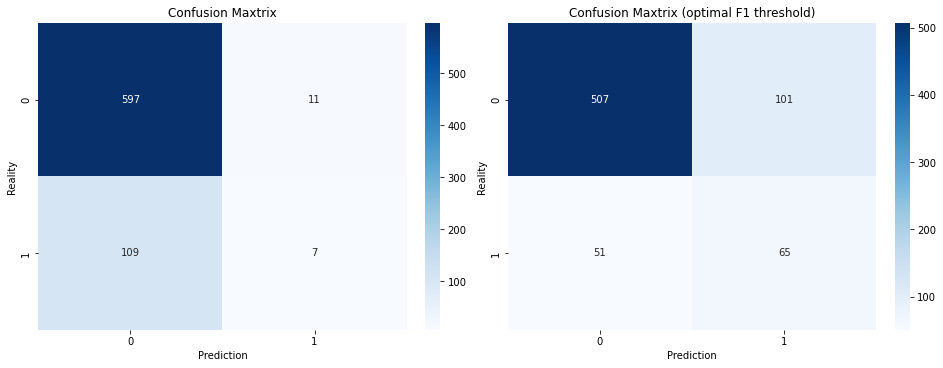

In [49]:
visualize_tests(probs1, target_test)

In [50]:
probs2 = best_xgb.predict_proba(features_test)[:,1]

Processing validation set, please wait warmly...
F1: 0.18 (max: 0.36 at 0.08 threshold), ROC_AUC: 0.642, accuracy: 80%, AP (PR_AUC): 0.25


0.079405546

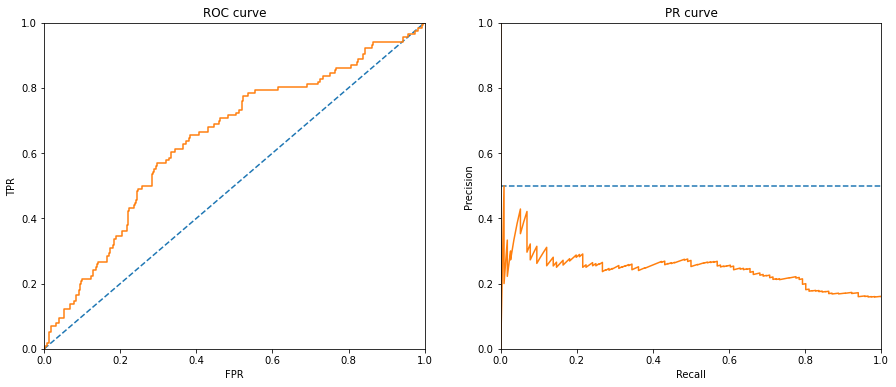

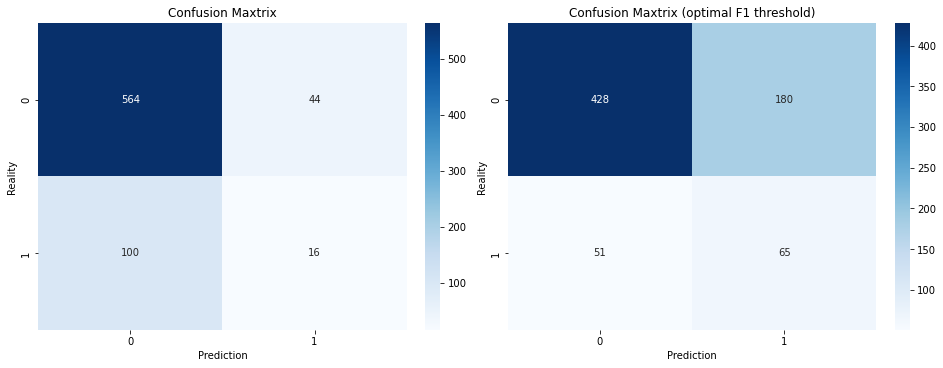

In [51]:
visualize_tests(probs2, target_test)

In [52]:
probs3 = best_et.predict_proba(features_test)[:,1]

Processing validation set, please wait warmly...
F1: 0.12 (max: 0.42 at 0.22 threshold), ROC_AUC: 0.721, accuracy: 84%, AP (PR_AUC): 0.34


0.22

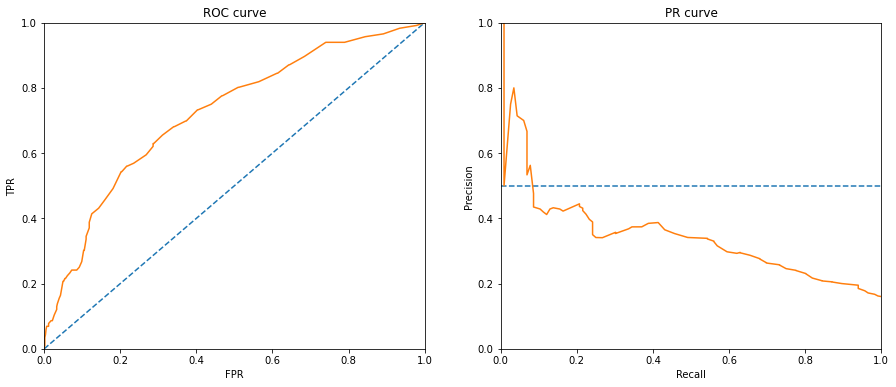

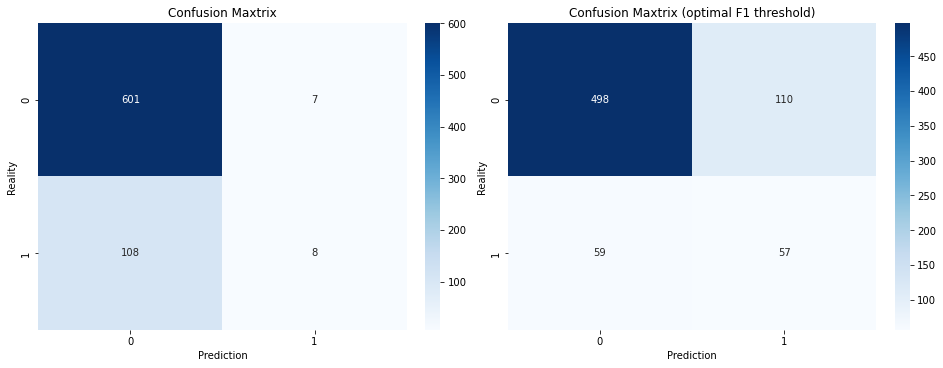

In [53]:
visualize_tests(probs3, target_test)

## Feature importance

Sorting features by their contribution to metrics may provide more insight on what features to keep:

In [54]:
def importance_summary(model_list, X_test, y_test, feature_names):
    importances = pd.DataFrame()
    model_legend = [f'{type(model[1]).__name__}' for model in model_list]
    
    for model in model_list:
        importance = permutation_importance(model,
                                            X_test.astype('float32'),
                                            y_test,
                                            random_state=RANDOM_STATE).importances_mean
        importances = importances.append (pd.Series(importance, index=feature_names),
                                          ignore_index=True)
    
    # Normalizing:
    importances = importances.div(importances.sum (axis=1), axis=0)
    importances.T.plot(kind='bar', figsize=(12,6), width=0.7).set(title="Permutation importance",
                                                                  ylabel="Importance (normalized)");
    plt.legend(model_legend);

In [55]:
models = [best_linear, best_forest, best_et, best_xgb]

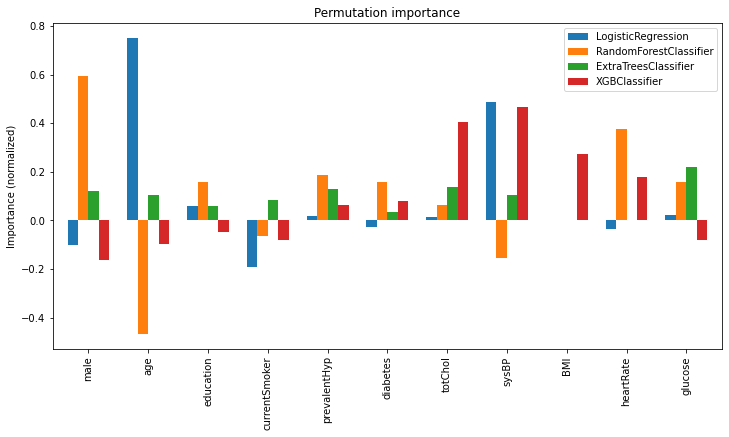

In [56]:
importance_summary(models, features_test, target_test, features_test.columns)